In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv(os.getenv('RFM_DATA_LOCATION'), encoding='unicode_escape')
print(data.info())
print(data.head())
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED 

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


### Here we can see there is null values in CustomerID and there is values belove 0 at Quantity and UnitPrice. Let's clean those

In [3]:
data = data[data['Quantity'] > 0]
data = data[data['UnitPrice'] > 0]
data = data[~(data['CustomerID'].isnull())].reset_index(drop=True)
print(data.info())
print(data.head())
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.3+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED 

,count,mean,std,min,25%,50%,75%,max
Quantity,397884.0,12.988238,179.331775,1.000,2.00,6.00,12.00,80995.00
UnitPrice,397884.0,3.116488,22.097877,0.001,1.25,1.95,3.75,8142.75
CustomerID,397884.0,15294.423453,1713.141560,12346.000,13969.00,15159.00,16795.00,18287.00


### Cleaned all null values inside of the CustomerID

### There is some questions from our business team

 1. The 10 best and 10 worst countries where we sell the most products and make the most profit
 2. Our top 10 customers
 3. Our 10 best-selling products

### 1- Top 10 Best and Worst Countries 

In [4]:
# Calculating the amount of sales: quantity * unit price
data['TotalCost'] = data['Quantity'] * data['UnitPrice']

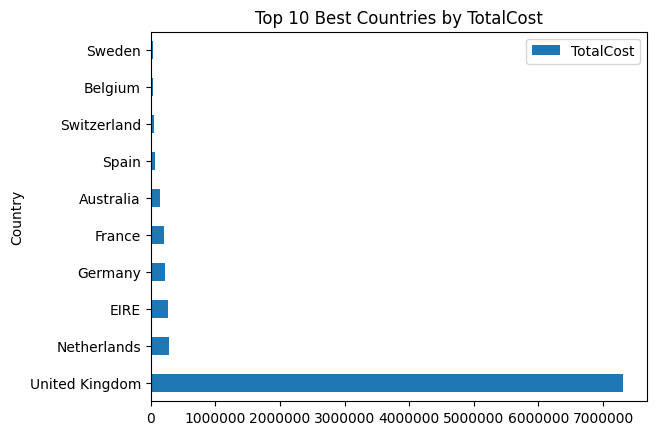

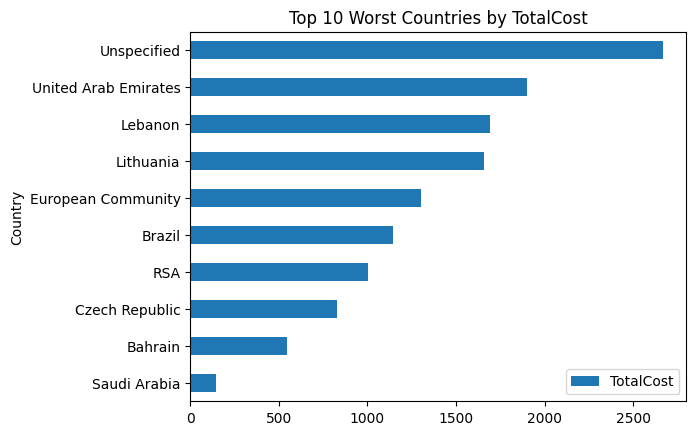

In [5]:
data.groupby('Country').agg({'TotalCost':'sum'}).sort_values(by='TotalCost',ascending=False).head(10).plot(kind='barh')
plt.ticklabel_format(style='plain', axis='x')
plt.title('Top 10 Best Countries by TotalCost')
plt.show()

data.groupby('Country').agg({'TotalCost':'sum'}).sort_values(by='TotalCost',ascending=False).tail(10).plot(kind='barh')
plt.ticklabel_format(style='plain', axis='x')
plt.title('Top 10 Worst Countries by TotalCost')
plt.gca().invert_yaxis()
plt.show()

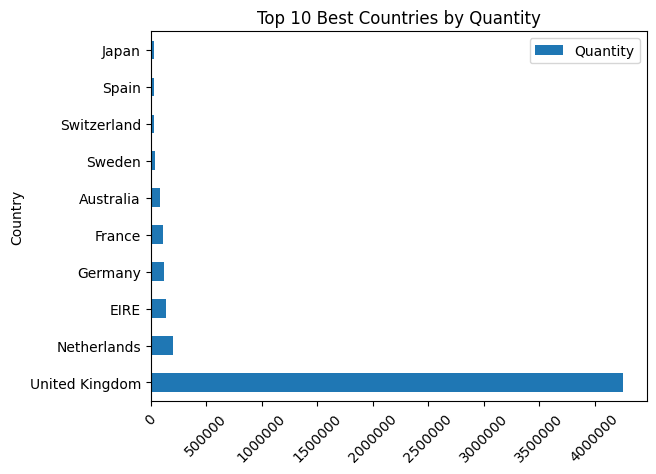

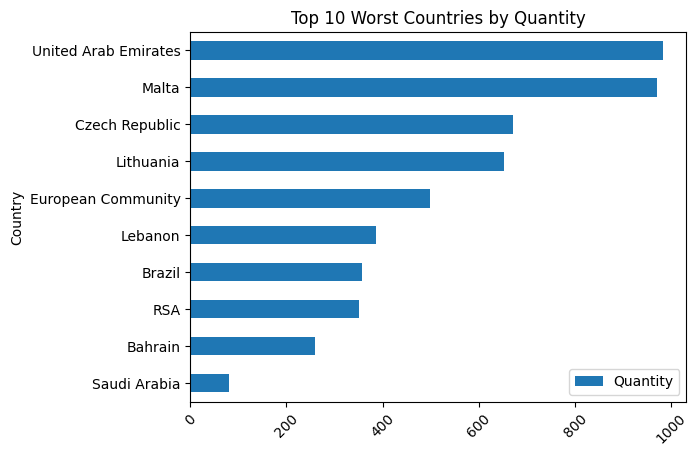

In [6]:
data.groupby('Country').agg({'Quantity':'sum'}).sort_values(by='Quantity',ascending=False).head(10).plot(kind='barh')
plt.ticklabel_format(style='plain', axis='x')
plt.title('Top 10 Best Countries by Quantity')
plt.xticks(rotation=45)
data.groupby('Country').agg({'Quantity':'sum'}).sort_values(by='Quantity',ascending=False).tail(10).plot(kind='barh')
plt.ticklabel_format(style='plain', axis='x')
plt.title('Top 10 Worst Countries by Quantity')
plt.gca().invert_yaxis()
plt.xticks(rotation=45)
plt.show()

### 2- Our Top 10 Customers

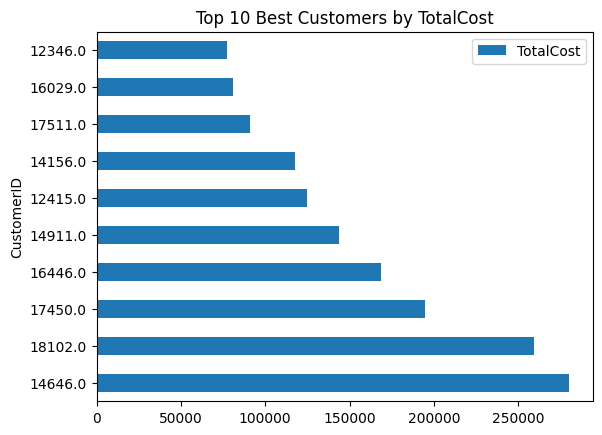

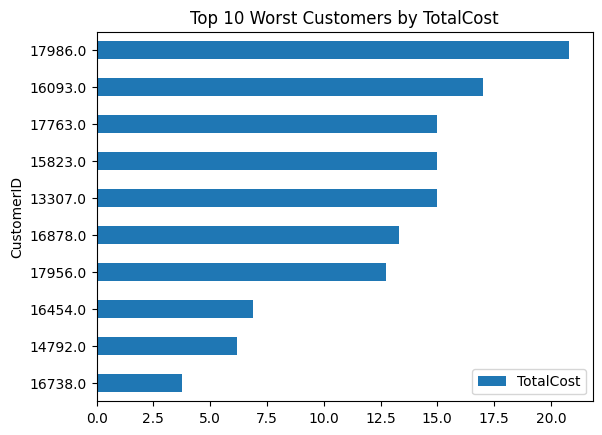

In [7]:
data.groupby('CustomerID').agg({'TotalCost':'sum'}).sort_values(by='TotalCost', ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Best Customers by TotalCost')
data.groupby('CustomerID').agg({'TotalCost':'sum'}).sort_values(by='TotalCost', ascending=False).tail(10).plot(kind='barh')
plt.title('Top 10 Worst Customers by TotalCost')
plt.gca().invert_yaxis()
plt.show()

### 3- Top 10 Best-Selling Products

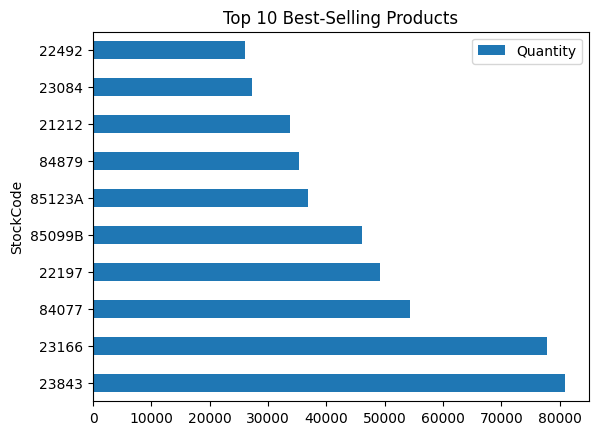

In [8]:
data.groupby('StockCode').agg({'Quantity':'sum'}).sort_values(by='Quantity', ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Best-Selling Products')
plt.show()

### Our business team's questions answered. Now let's calculate RFM metrics

In [9]:
ref_date = pd.to_datetime(data['InvoiceDate']).max() + pd.Timedelta(days=1)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
rfm_data = data.groupby('CustomerID').agg({"InvoiceDate": lambda InvoiceDate: (ref_date - InvoiceDate.min()).days,
                                           "InvoiceNo":lambda x: x.nunique(),
                                           "TotalCost":lambda x: x.sum()}).reset_index().rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalCost':'Monetary'})
rfm_data

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,367,7,4310.00
2,12348.0,358,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40
...,...,...,...,...
4333,18280.0,278,1,180.60
4334,18281.0,181,1,80.82
4335,18282.0,126,2,178.05
4336,18283.0,337,16,2094.88


In [10]:
rfm_data['recency_score'] = pd.qcut(rfm_data['Recency'], 5, labels=['5', '4', '3', '2', '1'])
rfm_data['frequency_score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), 5, labels=['1', '2', '3', '4', '5'])
rfm_data['rf_score'] = rfm_data['recency_score'].astype(str) + rfm_data['frequency_score'].astype(str)
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,rf_score
0,12346.0,326,1,77183.60,2,1,21
1,12347.0,367,7,4310.00,1,5,15
2,12348.0,358,4,1797.24,1,4,14
3,12349.0,19,1,1757.55,5,1,51
4,12350.0,310,1,334.40,2,1,21


### Creating our segments

In [11]:
segmentation_map={
    r"[1-2][1-2]":"k.hibernating",
    r"[1-2][3-4]":"j.at_risk",
    r"[1-2]5":"h.cant_loose",
    r"3[1-2]":"g.about_to_sleep",
    r"33":"f.need_attention",
    r"[3-4][4-5]":"e.loyal_customers",
    r"41":"d.promising",
    r"51":"c.new_customers",
    r"[4-5][2-3]":"b.potential_loyalists",
    r"5[4-5]":"a.champions"
}
rfm_data["segment"]=rfm_data["rf_score"].replace(segmentation_map,regex=True)
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,rf_score,segment
0,12346.0,326,1,77183.60,2,1,21,k.hibernating
1,12347.0,367,7,4310.00,1,5,15,h.cant_loose
2,12348.0,358,4,1797.24,1,4,14,j.at_risk
3,12349.0,19,1,1757.55,5,1,51,c.new_customers
4,12350.0,310,1,334.40,2,1,21,k.hibernating


In [12]:
rfm_data.groupby('segment').agg({'Recency':'mean','Frequency':'mean','Monetary':'mean','segment':'count'})

,Recency,Frequency,Monetary,segment
segment,,,,
a.champions,57.790698,4.279070,1674.766512,86
b.potential_loyalists,95.838202,1.659551,825.204024,890
c.new_customers,41.602941,1.000000,417.427000,340
d.promising,139.714286,1.000000,425.507094,203
e.loyal_customers,212.321678,5.431818,2091.856767,572
f.need_attention,246.408867,2.339901,839.527488,203
g.about_to_sleep,246.669903,1.152104,438.458579,309
h.cant_loose,348.903274,13.979167,7700.376979,672
j.at_risk,333.829023,3.400862,1290.721568,696


## Results of RFM Analysis


+ Can't loose customers has high recency value. We can start a new CRM campaign for them. For example, we send them an email about their most purchased products to attract them.

+ For customers in the at risk and hibernating segments, it may be useful to find out why they have not shopped for so long. Because we have about 1500 clients and they have a high monetary value. If necessary, we can collect information from them via email or sms and remind ourselves.

+ It's been over a month since I shopped at new customers. These customers can be reminded of their most recent purchases and offered relevant products or we can send an email for thanks to their purchases.

+ Loyal customers can be emailed about the products they buy the most.

+ Instead of investing in about to sleep customers, it makes more sense to invest in existing customers (e.g. champions, potential loyalists).

+ Return campaigns can be offered for customers who have not been with us for a long time. (e.g hibernating, at risk, need attention)